In [7]:
%pip install captum

import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # self.layers = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(28*28, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 10),
        #)
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(28*28, 16) # 12560 parameters
        self.layer2 = nn.Linear(16, 16) # 272 parameters
        self.layer3 = nn.Linear(16, 10) # 170 parameters
        # Total parameter count = 13002 parameters

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        return x

# Create the model
model = MLP()

# Create a loader with the MNIST dataset
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [50000, 10000])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

# Set loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
for epoch in range(20):  # number of times to loop over the dataset
    for images, labels in train_loader:
        # Convert labels to one-hot encoding
        labels_one_hot = F.one_hot(labels, num_classes=10).float()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = loss_fn(outputs, labels_one_hot)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Training Epoch {epoch+1}, Loss: {loss.item()}')

    # Validation step
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    print(f'Validation Accuracy after Epoch {epoch+1}: {accuracy}%')

Note: you may need to restart the kernel to use updated packages.
Training Epoch 1, Loss: 0.056737929582595825
Validation Accuracy after Epoch 1: 73.19%
Training Epoch 2, Loss: 0.041288308799266815
Validation Accuracy after Epoch 2: 82.85%
Training Epoch 3, Loss: 0.02688463404774666
Validation Accuracy after Epoch 3: 86.31%
Training Epoch 4, Loss: 0.028762364760041237
Validation Accuracy after Epoch 4: 88.22%
Training Epoch 5, Loss: 0.025920238345861435
Validation Accuracy after Epoch 5: 89.1%
Training Epoch 6, Loss: 0.021637793630361557
Validation Accuracy after Epoch 6: 89.48%
Training Epoch 7, Loss: 0.01628810539841652
Validation Accuracy after Epoch 7: 89.77%
Training Epoch 8, Loss: 0.015260977670550346
Validation Accuracy after Epoch 8: 90.22%
Training Epoch 9, Loss: 0.020436298102140427
Validation Accuracy after Epoch 9: 90.46%
Training Epoch 10, Loss: 0.01724102720618248
Validation Accuracy after Epoch 10: 90.65%
Training Epoch 11, Loss: 0.02058819867670536
Validation Accuracy a

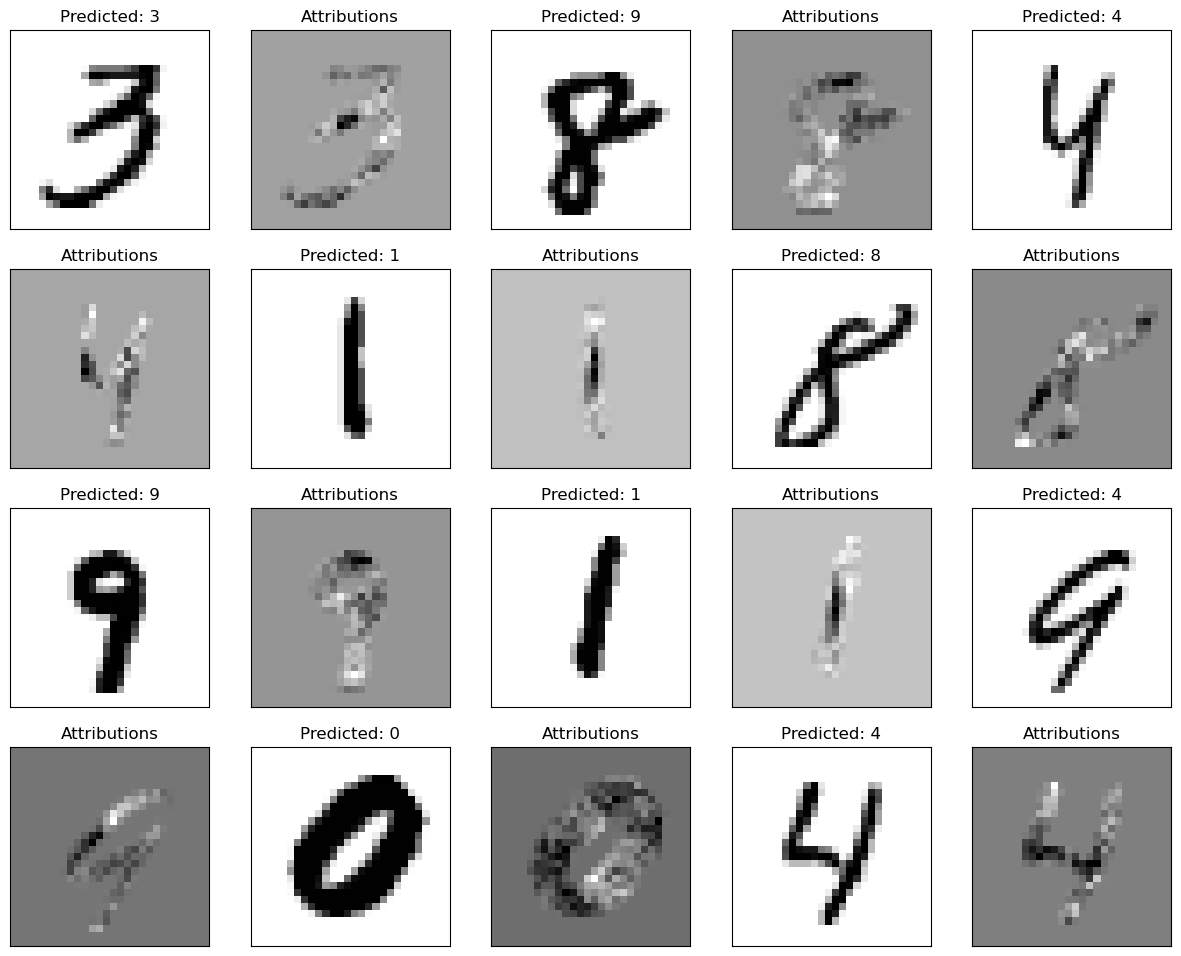

In [8]:
# Inference
model.eval()
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
images, labels = next(iter(test_loader))
with torch.no_grad():
    outputs = model(images)

_, predicted = torch.max(outputs, 1)

# Integrated Gradients
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(images, target=predicted, return_convergence_delta=True)

# Plot the images with the predicted labels and attributions
plt.figure(figsize=(15, 15))
for i in range(10):
    plt.subplot(5, 5, i*2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.title('Predicted: ' + str(predicted[i].item()))
    
    plt.subplot(5, 5, i*2 + 2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(attributions[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.title('Attributions')
plt.show()